In [4]:
try:
    from google.colab import drive
    NOTEBOOK = 'colab'
except:
    import os    
    if list(os.walk('/kaggle/input')):            
        NOTEBOOK = 'kaggle'
    else:
        NOTEBOOK = 'home'
        
if NOTEBOOK == 'colab':
    drive.mount("/content/gdrive", force_remount=True)

import tensorflow as tf
# tf.debugging.set_log_device_placement(True)
# tf.config.set_visible_devices([], 'GPU') 
# tf.executing_eagerly() 

print(NOTEBOOK)




home


In [5]:
if NOTEBOOK == 'colab':
    !pip install -q dm-sonnet
    !pip install -q gdown
    import gdown    
#     url = 'https://drive.google.com/uc?id=1Si-Fz-38xITBOvYOoPTn_xLtOHVwqFQO'
    url = 'https://drive.google.com/uc?id=1_ndJOdlaVenrnMvo9dIVja8mBCNZP6AG'
    output = 'GOLD_XYZ.hdf5'
    gdown.download(url, output, quiet=False)
    !df -h
    !ls -l
    !grep Model: /proc/driver/nvidia/gpus/*/information | awk '{$1="";print$0}'
    hdf5_path = '/content/'+output
elif NOTEBOOK == 'kaggle':
    !pip install -q dm-sonnet
    import os
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            hdf5_path = os.path.join(dirname, filename)
else:          
    hdf5_path = '/media/bognev/CE50072F50071DB9/2018.01/GOLD_XYZ_OSC.0001_1024.hdf5'
print(hdf5_path)


/media/bognev/CE50072F50071DB9/2018.01/GOLD_XYZ_OSC.0001_1024.hdf5


In [6]:
# import tensorflow as tf
# tf.debugging.set_log_device_placement(True)
# import h5py
import numpy as np
import matplotlib.pyplot as plt
import random
import tqdm
import time
import h5py
import sonnet as snt
from tqdm import tqdm

print("TensorFlow version: {}".format(tf.__version__))
print("    Sonnet version: {}".format(snt.__version__))
print("    Numpy  version: {}".format(np.__version__))
from tensorboard import version; print("TensorBoard version: {}".format(version.VERSION))
# tf.config.list_physical_devices('GPU')

TensorFlow version: 2.1.0
    Sonnet version: 2.0.0
    Numpy  version: 1.18.2
TensorBoard version: 2.2.0


In [7]:
class ConvMaxPool(snt.Module):
    def __init__(self, name=None):
        super(ConvMaxPool, self).__init__(name=name)
        self.conv = snt.Conv1D(output_channels=64, kernel_shape=64, stride=1, rate=1,
                               padding="SAME", with_bias=True,
                               data_format="NWC", name="conv_max_pool"
                               )

    def __call__(self, inputs):
        features = self.conv(inputs)
        outputs = tf.nn.max_pool1d(features, ksize=2, strides=2, padding="VALID", 
                                   data_format='NWC', name="pool") #64×1024
        return outputs


class CNN(snt.Module):
    def __init__(self, epsilon, name=None):
        super(CNN, self).__init__(name=name)
        self.layers = [
            ConvMaxPool(name="conv"+str(ii))
            for ii in range(6)
        ]
        self.conv_in = snt.Conv1D(output_channels=64, kernel_shape=2, stride=1, rate=1,
                       padding="SAME", with_bias=True,
                       data_format="NWC", name="conv_input"
                       )

        self.linear = snt.Linear(output_size=128, with_bias=True)
        self.linear1 = snt.Linear(output_size=128, with_bias=True)
        self.linear2 = snt.Linear(output_size=24, with_bias=True)                
        
        self.alpha = tf.keras.layers.AlphaDropout(rate=0.5, noise_shape=None, seed=100)

    @tf.function
    def __call__(self, inputs, is_training=False):
        features = self.conv_in(inputs) #2×1024
        features = tf.nn.max_pool1d(features, ksize=2, strides=2, padding="VALID", 
                                    data_format='NWC', name="pool_input") 
#         print(features)
        for layer in self.layers:
            features = layer(features)    
        features = snt.flatten(features)

        features = self.linear(features)
        features = self.alpha(tf.nn.selu(features), training=is_training)
        features = self.linear1(features)
        features = self.alpha(tf.nn.selu(features), training=is_training)

        output = self.linear2(features)        
#         output = tf.nn.softmax(features)
        return output


In [8]:
class CNNOptimizer(snt.Module):
    def __init__(self, name, cnn, lr=1e-3, num_epochs=100, decay_lr_start_epoch=10, decay_lr=False):
        super(CNNOptimizer, self).__init__(name=name)
        self.cnn = cnn
        self.init_lr = lr
        self.lr = tf.Variable(lr, trainable=False, name='learning rate', dtype=tf.float32)
        self.cnn_opt = snt.optimizers.Adam(learning_rate=self.lr, beta1=0.)
        self.decay_lr_start_epoch = tf.constant(decay_lr_start_epoch, dtype=tf.int32)
        self.decay_lr = tf.constant(decay_lr, dtype=tf.float32)
        self.num_epochs = tf.constant(num_epochs, dtype=tf.int32)

    def _gen_lr_mult(self, epoch):
          # Linear decay to 0.
        decay_epoch = tf.cast(epoch - self.decay_lr_start_epoch, tf.float32)
        if decay_epoch < tf.constant(0, dtype=tf.float32):
            return tf.constant(1., dtype=tf.float32)
        num_decay_epochs = tf.cast(self.num_epochs - self.decay_lr_start_epoch, dtype=tf.float32)
        return (num_decay_epochs - decay_epoch) / num_decay_epochs        
      
    def step(self, batch, labels, epoch):
        with tf.GradientTape() as tape:
            logits = self.cnn(batch, is_training=True)    
            loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)
            loss = tf.reduce_mean(loss)
        params = self.cnn.trainable_variables
        grads = tape.gradient(loss, params)                
        lr_mult = self._gen_lr_mult(epoch)
        if self.decay_lr:
            self.lr.assign(self.init_lr * lr_mult)
        self.cnn_opt.apply(grads, params)
        return loss
    




In [12]:
class radioML:
    def __init__(self, file, batch_size, is_training=False):
        self.file = file
        self.batch_size = batch_size
        self.is_training = is_training

    def __call__(self):        
        N_r, N_m, N_db = 4096, 24, 13
        if NOTEBOOK == 'colab':            
            dbs = np.arange(0,32,2)     
            db_range = np.arange(0,0+len(dbs))
        else:                       
            dbs = np.arange(0,32,2)                   
            db_range = np.arange(10,10+len(dbs))
        data_idxs_train = np.array([])
        data_idxs_test = np.array([])
        for i in np.arange(N_m):            
            for j in db_range:
                ids = i*N_r*N_db+j*N_r
                idx = np.arange(ids, ids+N_r)                
                data_idxs_train = np.append(data_idxs_train, idx[np.arange(int(0.8*N_r))])
                data_idxs_test  = np.append(data_idxs_test, idx[np.arange(int(0.8*N_r)+1, N_r)])
        with h5py.File(self.file, 'r') as f:
            while True:
                if self.is_training:
                    idxs = np.random.choice(data_idxs_train, self.batch_size)
                    yield (f['X'][sorted(idxs)], f['Y'][sorted(idxs)])
                else:
                    idxs = np.random.choice(data_idxs_test, self.batch_size)
                    yield (f['X'][sorted(idxs)], f['Y'][sorted(idxs)])
                

def radioML_map(data_batch, data_label):
#     print(data_batch.shape)
    data_batch = tf.reshape(data_batch, [1024, 2])
    data_label = tf.reshape(data_label, [24])
#     mean = tf.math.reduce_mean(data_batch)
#     std = tf.math.reduce_std(data_batch)
#     data_batch = (data_batch - mean)/std
#     print(std, mean)
#     print(type(std))
    return (data_batch, data_label)

<dtype: 'int32'>


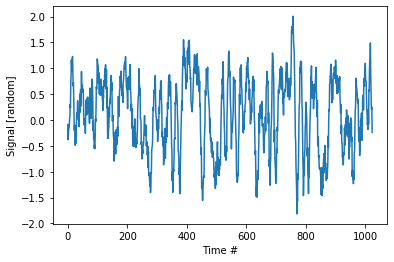

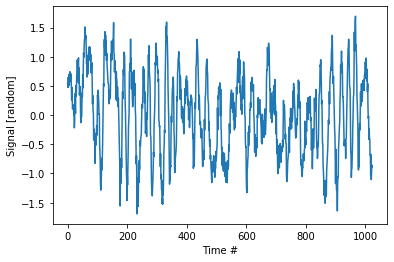

In [13]:
radio_plot = tf.data.Dataset.from_generator(radioML(hdf5_path, 1, False), 
                output_types=(tf.float32, tf.int32),
                output_shapes=(tf.TensorShape([1, 1024, 2]), tf.TensorShape([1, 24]))) #2555904, 1024, 2]

radio_plot = radio_plot.take(1)
radio_plot = radio_plot.map(radioML_map)
for (batch, labels) in radio_plot:    
    print(labels.dtype)
    fig1 = plt.figure()
    plt.plot(batch[:,0])
    plt.xlabel('Time #')
    plt.ylabel('Signal [random]')
    fig2 = plt.figure()
    plt.plot(batch[:,1])
    plt.xlabel('Time #')
    plt.ylabel('Signal [random]')
    plt.show()

In [8]:
# building tensorflow graph

# from datetime import datetime as dt
# # Clear any logs from previous runs
# !rm -rf ./logs/

# stamp = dt.now().strftime("%Y%m%d-%H%M%S")
# logdir = 'logs/func/%s' % stamp
# writer = tf.summary.create_file_writer(logdir)

# radio_model = CNN(epsilon=1e-8, name="CNN")
# radio_data_test = tf.data.Dataset.from_generator(radioML(hdf5_path, 1, False), 
#                 output_types=(tf.float32, tf.float32),
#                 output_shapes=(tf.TensorShape([1, 1024, 2]), tf.TensorShape([1, 24]))) #2555904, 1024, 2]
# radio_data_test = radio_data_test.take(1)
# radio_data_test = radio_data_test.map(radioML_map)
# radio_data_test = radio_data_test.batch(1)

# for i,(batch, labels) in enumerate(radio_data_test):
#     tf.summary.trace_on(graph=True, profiler=True)    
#     preds = radio_model(batch)
#     with writer.as_default():
#         tf.summary.trace_export(
#             name='tf2_graph',
#             step=0,
#             profiler_outdir=logdir)
# %reload_ext tensorboard
# %tensorboard --logdir logs/func     

In [9]:
if NOTEBOOK != 'kaggle':
    # %load_ext tensorboard
    # import os
    from datetime import datetime as dt
    # Clear any logs from previous runs
    !rm -rf ./logs/
    log_dir = "logs/scalars/" + dt.now().strftime("%Y%m%d-%H%M%S")
    writer = tf.summary.create_file_writer(log_dir)


    %reload_ext tensorboard
#     %tensorboard --logdir logs/func     
    # writer.set_as_default()
    %tensorboard --logdir logs/scalars

Reusing TensorBoard on port 6006 (pid 10008), started 2:12:10 ago. (Use '!kill 10008' to kill it.)

In [11]:

batch_size = 32
num_batches = int(1572864/batch_size)
# num_batches = 5
num_epochs = 10

radio_model = CNN(epsilon=1e-8, name="CNN")
radio_opt = CNNOptimizer(name="Optimizer", cnn=radio_model, lr=0.001, \
                         num_epochs=num_epochs, decay_lr_start_epoch=2, decay_lr=True)

t = tqdm(range(num_batches * num_epochs),
               unit='sig', unit_scale=batch_size, position=0)


radio_data_train = tf.data.Dataset.from_generator(radioML(hdf5_path, 1, True), 
                output_types=(tf.float32, tf.int32),
                output_shapes=(tf.TensorShape([1, 1024, 2]), tf.TensorShape([1, 24]))) #2555904, 1024, 2]

radio_data_test = tf.data.Dataset.from_generator(radioML(hdf5_path, 1, False), 
                output_types=(tf.float32, tf.int32),
                output_shapes=(tf.TensorShape([1, 1024, 2]), tf.TensorShape([1, 24]))) #2555904, 1024, 2]

loss = 0

radio_data_train = radio_data_train.take(batch_size*num_batches)
radio_data_train = radio_data_train.map(radioML_map)
radio_data_train = radio_data_train.batch(batch_size)
radio_data_train = radio_data_train.prefetch(tf.data.experimental.AUTOTUNE)
radio_data_train = radio_data_train.repeat(num_epochs)
radio_data_train = radio_data_train.cache()

test = radio_data_test.take(1024)
test = test.map(radioML_map)
test = test.batch(batch_size)


# step = tf.function(radio_opt.step)
print_every = 2048

start_time = time.perf_counter()
for step_num,(batch, labels) in enumerate(radio_data_train):      
    epoch = tf.constant(1+int(step_num / (num_batches)))
    loss = radio_opt.step(batch, labels, epoch)
    
    if NOTEBOOK != 'kaggle':
        with writer.as_default():
            tf.summary.scalar('training loss', loss, step=step_num)
            tf.summary.scalar('learning rate', radio_opt.lr, step=step_num)    
        
    t.update(1)    
    if step_num % print_every == 0:                
        t.write('Current epoch = {}/{} (lr_mult = {:0.09f}, loss = {}) done.'.format(
            epoch.numpy(), num_epochs, radio_opt.lr.numpy(), loss.numpy()))  
        
    if step_num % num_batches == 0: 
        accuracy, total, correct = tf.constant(0), tf.constant(0), tf.constant(0)
        for (batch, labels) in test:            
            logits = tf.nn.softmax(radio_opt.cnn(batch, is_training=False))
            preds = tf.argmax(logits, axis=1, output_type=tf.int32)  
            labels = tf.argmax(labels, axis=1, output_type=tf.int32)
            correct += tf.math.count_nonzero(tf.equal(preds, labels), dtype=tf.int32)
            total += tf.shape(labels)[0]            
        accuracy = (correct / tf.cast(total, tf.int32)) * 100.          
        t.write('Epoch = {}/{} (lr_mult = {:0.09f}, loss = {:0.02f}, accuracy = {:0.02f}, incorrect = {} done.'.format(
            epoch.numpy(), num_epochs, radio_opt.lr.numpy(), loss.numpy(), accuracy, total - correct))  
                 
print("Execution time:", time.perf_counter() - start_time)   
t.close()
   

  2%|▏         | 32/1600 [00:02<01:39, 15.73sig/s]

Epoch = 1/10 (lr_mult = 0.001000000, loss = 3.4212646484375) done.


  2%|▏         | 32/1600 [00:03<01:39, 15.73sig/s]

Epoch = 1/10 (lr_mult = 0.001000000, loss = 3.42, accuracy = 2.64, incorrect = 997 done.


 12%|█▏        | 192/1600 [00:06<00:39, 35.37sig/s]

Epoch = 2/10 (lr_mult = 0.001000000, loss = 52.96, accuracy = 3.71, incorrect = 986 done.


 22%|██▏       | 352/1600 [00:10<00:26, 47.74sig/s]

Epoch = 3/10 (lr_mult = 0.000875000, loss = 47.48, accuracy = 4.39, incorrect = 979 done.


 32%|███▏      | 512/1600 [00:13<00:21, 49.97sig/s]

Epoch = 4/10 (lr_mult = 0.000750000, loss = 4.12, accuracy = 4.30, incorrect = 980 done.


 42%|████▏     | 672/1600 [00:16<00:17, 51.89sig/s]

Epoch = 5/10 (lr_mult = 0.000625000, loss = 3.73, accuracy = 4.88, incorrect = 974 done.


 52%|█████▏    | 832/1600 [00:20<00:14, 53.10sig/s]

Epoch = 6/10 (lr_mult = 0.000500000, loss = 3.59, accuracy = 3.71, incorrect = 986 done.


 62%|██████▏   | 992/1600 [00:23<00:11, 51.55sig/s]

Epoch = 7/10 (lr_mult = 0.000375000, loss = 3.32, accuracy = 4.88, incorrect = 974 done.


 72%|███████▏  | 1152/1600 [00:26<00:08, 51.99sig/s]

Epoch = 8/10 (lr_mult = 0.000250000, loss = 3.56, accuracy = 5.66, incorrect = 966 done.


 82%|████████▏ | 1312/1600 [00:30<00:05, 50.63sig/s]

Epoch = 9/10 (lr_mult = 0.000125000, loss = 3.44, accuracy = 4.30, incorrect = 980 done.


 92%|█████████▏| 1472/1600 [00:33<00:02, 51.48sig/s]

Epoch = 10/10 (lr_mult = 0.000000000, loss = 3.61, accuracy = 4.59, incorrect = 977 done.


100%|██████████| 1600/1600 [00:34<00:00, 45.82sig/s]

Execution time: 34.87727910599824


In [11]:
radio_data_test = tf.data.Dataset.from_generator(radioML(hdf5_path, 1, False), 
                output_types=(tf.float32, tf.int32),
                output_shapes=(tf.TensorShape([1, 1024, 2]), tf.TensorShape([1, 24]))) #2555904, 1024, 2]
test = radio_data_test.take(1024)
test = test.map(radioML_map)
test = test.batch(batch_size)
for (batch, labels) in test:
    preds = tf.argmax(radio_opt.cnn(batch), output_type=tf.int32)
    correct += tf.math.count_nonzero(tf.equal(preds, labels), dtype=tf.int32)
    total += tf.shape(labels)[0]
accuracy = (correct / tf.cast(total, tf.int32)) * 100.   
print("Final accuracy:", accuracy)

Final accuracy: tf.Tensor(87.646484375, shape=(), dtype=float64)


In [ ]:
tf.math.is_nan(loss_history)
loss_history = loss_history
fig2 = plt.figure()
plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')
plt.show()
loss_history

In [ ]:
print(snt.format_variables(radio_model.variables))